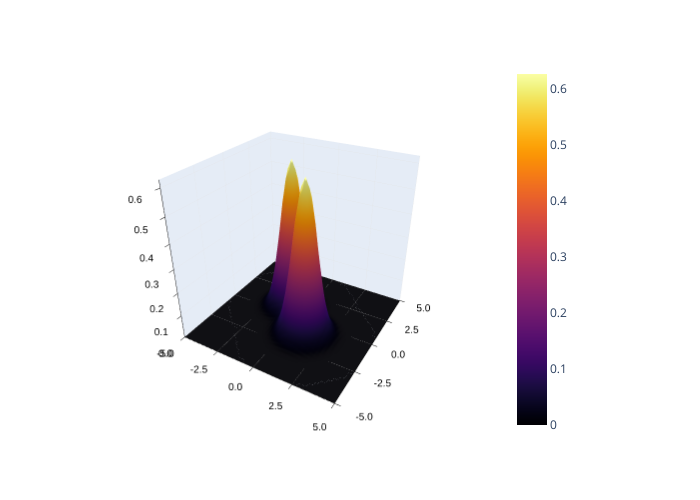

In [49]:
using Plots; plotlyjs()
using LinearAlgebra
using BenchmarkTools

freePropagator(finPos, startPos, finTime, startTime = 0, m = 1) = sqrt(m / (2 * pi * im * (finTime - startTime))) * exp(im * m / (2 * (finTime - startTime)) * (finPos - startPos)^2)  
freePropagatorC(qf, qfp, q0, q0p, tf, t0) = freePropagator(qf, q0, tf, t0) * freePropagator(qfp, q0p, tf, t0)
initStateFunction(q0, q0p, σ1, s1, p1, σ2, s2, p2) = (1//2 * pi * σ1)^(1//4) * exp(-(q0 - s1)^2 / (4 * σ1^2) + im * p1 * q0) * (1//2 * pi * σ2)^(1//4) * exp(-(q0p - s2)^2 / (4 * σ2^2) + im * p2 * q0p)
springPropagator1(qf, qfp, q0, q0p, tf, t0) = freePropagatorC(qf, qfp, q0, q0p, tf, t0) * (1 - im * α * tf / 6 * (-2 * (m * (q0 + qf)^2 + m * (q0p + qfp)^2 + im * tf) + 2*q0*q0p + q0*qfp + q0p*qf + 2*qf*qfp))

maxPos = 5
minPos = -5
stepPos = 0.25

pos1Vect = collect(minPos:stepPos:maxPos)
pos2Vect = collect(minPos:stepPos:maxPos)
posVectSize = size(pos1Vect, 1)
posMat = [(i, j) for i in pos1Vect, j in pos2Vect]

posToIndex(pos) = Int32((pos - minPos) / stepPos  + 1)

# Unentangled
# initState(q) = initStateFunction(q[1], q[2], 0.5, 0, 0, 0.5, 0, 0)
# Entangled
initState(q) = 1/sqrt(2) * (initStateFunction(q[1], q[2], 0.5, +1, 0, 0.5, -1, 0) + initStateFunction(q[1], q[2], 0.5, -1, 0, 0.5, +1, 0))
initMat = initState.(posMat)
initMat = round.(initMat, digits = 7)

α = 2
m = 1

surface(pos1Vect, pos2Vect, abs.(initMat))

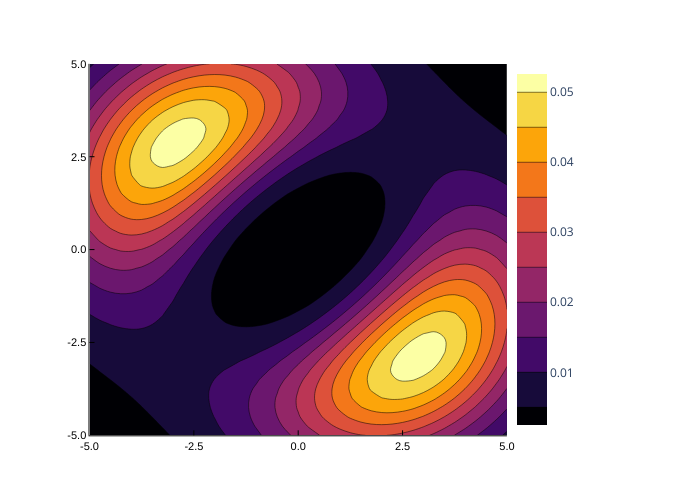

In [59]:
# The bruteforce integral approach

# Unentangled
initState(q) = initStateFunction(q[1], q[2], 0.5, 0, 0, 0.5, 0, 0)
# Entangled
# initState(q) = 1/sqrt(2) * (initStateFunction(q[1], q[2], 0.5, +1, 0, 0.5, -1, 0) + initStateFunction(q[1], q[2], 0.5, -1, 0, 0.5, +1, 0))
initMat = initState.(posMat)
initMat = round.(initMat, digits = 7)

finalMat = Matrix{ComplexF32}(undef, posVectSize, posVectSize)
finalTime = 2

for xf in pos1Vect, xfp in pos2Vect
	sumPos = 0
	for i in 1:posVectSize
		Threads.@threads for j in 1:posVectSize
			x0 = pos1Vect[i]
			x0p = pos2Vect[j]
			sumPos += springPropagator1(xf, xfp, x0, x0p, finalTime, 0) * initMat[i, j]
		end
	end
	finalMat[posToIndex(xf), posToIndex(xfp)] = sumPos
end
contourf(pos1Vect, pos2Vect, normalize(abs2.(finalMat)))